In [1]:
import torch
import numpy as np
import random
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
plt.style.use('ggplot')

We will try our own toy transative closure to test their methods. We will use the Stanford Encyclopedia of Philosophy ontology kept by the Indiana Philosophy Ontology project (https://inpho.cogs.indiana.edu/).

We'll use a subtree that looks like this:

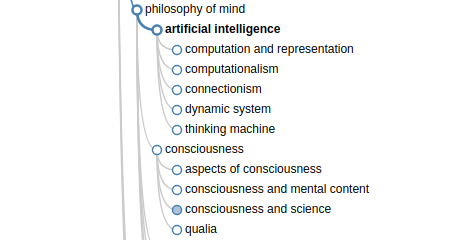

In [2]:
vocab_dict = {
    'philosophy of mind': 0,
    'artificial intelligence': 1,
    'computation and representation': 2,
    'computationalism': 3,
    'connectionism': 4,
    'dynamic system': 5,
    'thinking machine': 6,
    'consciousness': 7,
    'aspects of consciousness': 8,
    'consciousness and mental content': 9,
    'consciousness and science': 10,
    'qualia': 11}

The transitive closure matrix should then look like this:

In [205]:
trans_closure_und = np.array([
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],])
trans_closure_dir = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],])

In [55]:
# Global variables
vocab_size = trans_closure.shape[0]
embed_dim = 2
stability = 1e-6

In [5]:
#
# Data preparation

def get_pos_pairs(closure, n_words):
    pos_pairs = []
    for u in range(n_words):
        children = [v for v in np.nonzero(closure[u])[0]]
        if len(children) > 0:
            pos_pairs += list(zip([u] * len(children), children))
    return pos_pairs

def neg_samples(u, v, n_negs, closure):
    children = [vp for vp in np.nonzero(closure[u])[0]]
    nonchildren = [vp for vp in range(vocab_size)
                   if (vp not in children)]  # will capture u as we are supposed to
    num_negs = min(len(nonchildren), n_negs)
    return random.sample(nonchildren, num_negs)

def epoch_data(n_negs, n_words, closure):
    pos_pairs = get_pos_pairs(closure, n_words)
    # randomize order each epoch
    random.shuffle(pos_pairs)
    return [(u, v, neg_samples(u, v, n_negs, closure)) for u, v in pos_pairs]

In [65]:
#
# Math funcs

def arcosh(x):
    return torch.log(x + torch.sqrt(x**2 - 1))

def pdist(u, v):
    """Poincare distance."""
    uu = u.norm(dim=1)**2
    vv = v.norm(dim=1)**2
    uv = u.mm(v.t())
    numerator = uu - 2 * uv + vv
    denominator = (1 - uu).clamp(min=stability) * (1 - vv).clamp(min=stability)
    gamma = (1 + 2 * numerator / denominator).clamp(min=1 + stability)
    distance = arcosh(gamma)
    return distance

In [68]:
#
# Model

def loss(u, v, negs):
    """Loss for a positive pairs and negative samples.
    
    u, v, negs are all tensors by now (negs is matrix)
    """
    return -torch.log(torch.exp(-pdist(u, v)) / torch.exp(-pdist(u, negs)).sum())

In [128]:
#
# Optimization

def proj(theta):
    norm = theta.norm(p=2, dim=1).unsqueeze(1)
    norm[norm<1] = 1
    norm[norm>=1] += stability
    return theta.div(norm)

def scale_grad(delta):
    return ((1 - delta.norm()**2)**2) / 4. * delta

def update(embeds, lr, u_ix, v_ix, neg_ixs, u, v, negs):
    embeds[neg_ixs] -= lr*(((1-negs.norm(dim=1)**2)**2)/4.).data.unsqueeze(1)*negs.grad.data
    embeds[u_ix] -= lr*(((1-u.norm()**2)**2)/4.).data*u.grad.data
    embeds[v_ix] -= lr*(((1-v.norm()**2)**2)/4.).data*v.grad.data
    embeds = proj(embeds)

def forward(embeds, u_ix, v_ix, neg_ixs):
    """Calculate loss and gradient for the sample."""
    # unsqueezing yields row vectors; needed for vectorization of u.mm(negs^T) in pdist
    u = Variable(embeds[u_ix].unsqueeze(0), requires_grad=True)
    v = Variable(embeds[v_ix].unsqueeze(0), requires_grad=True)
    negs = Variable(embeds[neg_ixs], requires_grad=True)
    L = loss(u, v, negs)
    f_loss = L.data.numpy()[0][0]
    L.backward()
    return f_loss, u, v, negs

In [129]:
def pplot(vdict, pembs, name='Philosophy Ontology'):
    fig = plt.figure(figsize=(10,10)); ax = plt.gca(); ax.cla()
    ax.set_xlim((-1.1,1.1)); ax.set_ylim((-1.1,1.1))
    ax.add_artist(plt.Circle((0,0),1.,color='black',fill=False))
    fliers = []
    for w, i in vdict.items():
        emb = pembs[i]
        if emb.norm() > 1.:
            fliers.append(w)
        else:
            c0, c1 = pembs[i]
            ax.plot(c0, c1, 'o', color='y')
            ax.text(c0 +.01, c1+.01, w, color='b')
    if len(fliers) > 0:
        print('Words that flew out of the ball:')
        for flier in fliers:
            print('  * %s' % flier)
    plt.show()

In [200]:
def train(embeds, closure, vdict, n_negs, lr1, lr2):
    losses = []
    epoch = -1
    while len(losses) < 1 or np.average(losses) > 0.01:
        epoch += 1
        data = epoch_data(n_negs, len(vdict), closure)
        r = 1. * epoch / 200; 
        rate = (1 - r) * lr1 + r * lr2
        if epoch < 10:
            rate = rate / 10
        for u_ix, v_ix, neg_ixs in data:
            try:
                l, u, v, negs = forward(embeds, u_ix, v_ix, neg_ixs)
                losses.append(l)
                print('Loss: %s\tAverage: %s' % (l, np.average(losses)))
                update(embeds, rate, u_ix, v_ix, neg_ixs, u, v, negs)
            except Exception as e:
                print(embeds)
                raise e

In [208]:
embeddings = torch.Tensor(vocab_size, embed_dim)
torch.nn.init.uniform(embeddings, a=-0.001, b=0.001)
train(embeddings, trans_closure_dir, vocab_dict, 3, 0.2, 0.01)

Loss: 1.09886	Average: 1.09886
Loss: 1.09587	Average: 1.09736
Loss: 1.11552	Average: 1.10342
Loss: 1.11059	Average: 1.10521
Loss: 1.10268	Average: 1.1047
Loss: 1.08726	Average: 1.1018
Loss: 1.13413	Average: 1.10642
Loss: 1.08709	Average: 1.104
Loss: 1.09897	Average: 1.10344
Loss: 1.08788	Average: 1.10189
Loss: 1.11683	Average: 1.10324
Loss: 1.12453	Average: 1.10502
Loss: 1.1024	Average: 1.10482
Loss: 1.08162	Average: 1.10316
Loss: 1.10928	Average: 1.10357
Loss: 1.10411	Average: 1.1036
Loss: 1.09444	Average: 1.10306
Loss: 1.14173	Average: 1.10521
Loss: 1.09185	Average: 1.10451
Loss: 1.09591	Average: 1.10408
Loss: 1.10061	Average: 1.10391
Loss: 1.13966	Average: 1.10554
Loss: 1.11836	Average: 1.1061
Loss: 1.12141	Average: 1.10673
Loss: 1.13415	Average: 1.10783
Loss: 1.06456	Average: 1.10617
Loss: 1.11562	Average: 1.10652
Loss: 1.07431	Average: 1.10537
Loss: 1.05737	Average: 1.10371
Loss: 1.10154	Average: 1.10364
Loss: 1.12695	Average: 1.10439
Loss: 1.0886	Average: 1.1039
Loss: 1.07655	Ave

/home/hanshan/anaconda3/envs/py35/lib/python3.5/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


Loss: 1.15727	Average: 1.08776
Loss: 1.07736	Average: 1.08767
Loss: 1.13815	Average: 1.08813
Loss: 0.989095	Average: 1.08723
Loss: 0.996357	Average: 1.08642
Loss: 1.1806	Average: 1.08726
Loss: 1.12247	Average: 1.08757
Loss: 1.11388	Average: 1.08779
Loss: 0.991918	Average: 1.08697
Loss: 1.02941	Average: 1.08648
Loss: 1.13882	Average: 1.08692
Loss: 1.09355	Average: 1.08698
Loss: 1.09588	Average: 1.08705
Loss: 1.42218	Average: 1.08982
Loss: 0.985363	Average: 1.08896
Loss: 0.969249	Average: 1.08799
Loss: 0.830807	Average: 1.08592
Loss: 1.1839	Average: 1.0867
Loss: 0.940765	Average: 1.08554
Loss: 0.770741	Average: 1.08306
Loss: 1.22425	Average: 1.08417
Loss: 1.50843	Average: 1.08745
Loss: 1.13594	Average: 1.08783
Loss: 0.925595	Average: 1.08659
Loss: 1.31608	Average: 1.08833
Loss: 1.20815	Average: 1.08923
Loss: 1.20347	Average: 1.09008
Loss: 1.34899	Average: 1.092
Loss: 0.835252	Average: 1.09011
Loss: 0.727957	Average: 1.08747
Loss: 0.634279	Average: 1.08418
Loss: 0.907758	Average: 1.08291


Loss: 1.30565	Average: 0.765555
Loss: -0.00200809	Average: 0.763744
Loss: 1.93469	Average: 0.766499
Loss: -0.0703527	Average: 0.764535
Loss: 0.915211	Average: 0.764888
Loss: 0.694937	Average: 0.764724
Loss: 1.88284	Average: 0.767331
Loss: -0.178034	Average: 0.765132
Loss: 1.5647	Average: 0.766987
Loss: -0.456423	Average: 0.764155
Loss: 0.71524	Average: 0.764042
Loss: -0.0945067	Average: 0.762064
Loss: 0.826778	Average: 0.762213
Loss: 1.7559	Average: 0.764492
Loss: 0.234886	Average: 0.76328
Loss: 0.5794	Average: 0.76286
Loss: 0.245638	Average: 0.761682
Loss: 1.87918	Average: 0.764222
Loss: -1.91532	Average: 0.758146
Loss: 1.67165	Average: 0.760213
Loss: 2.0452	Average: 0.763113
Loss: 1.30072	Average: 0.764324
Loss: 1.3718	Average: 0.765689
Loss: -0.0853126	Average: 0.763781
Loss: 2.0793	Average: 0.766724
Loss: 0.375	Average: 0.76585
Loss: -1.27034	Average: 0.761315
Loss: 0.327237	Average: 0.76035
Loss: -0.355022	Average: 0.757877
Loss: -2.18863	Average: 0.751358
Loss: -0.444898	Average:

Loss: -2.10718	Average: 0.536946
Loss: -1.89498	Average: 0.533559
Loss: -3.88838	Average: 0.527409
Loss: 1.85	Average: 0.529246
Loss: 2.00816	Average: 0.531297
Loss: 0.362857	Average: 0.531064
Loss: -0.996225	Average: 0.528951
Loss: 0.64479	Average: 0.529111
Loss: 1.95247	Average: 0.531075
Loss: 0.304952	Average: 0.530763
Loss: -1.77755	Average: 0.527588
Loss: 1.80962	Average: 0.529349
Loss: 0.0988467	Average: 0.528759
Loss: -0.978748	Average: 0.526693
Loss: 0.7402	Average: 0.526986
Loss: 0.283122	Average: 0.526652
Loss: -1.05443	Average: 0.524495
Loss: -2.05235	Average: 0.520985
Loss: -1.18178	Average: 0.518668
Loss: 2.75493	Average: 0.521706
Loss: 1.79966	Average: 0.52344
Loss: -3.87391	Average: 0.517482
Loss: 0.629707	Average: 0.517634
Loss: 0.422406	Average: 0.517505
Loss: -0.787149	Average: 0.515744
Loss: -1.15435	Average: 0.513494
Loss: 0.150445	Average: 0.513005
Loss: 2.77082	Average: 0.51604
Loss: -2.26641	Average: 0.512305
Loss: 1.97949	Average: 0.514272
Loss: 0.0476278	Averag

Loss: -2.58004	Average: 0.357796
Loss: 4.02447	Average: 0.361405
Loss: 0.0686801	Average: 0.361117
Loss: -3.22208	Average: 0.357597
Loss: -1.01485	Average: 0.35625
Loss: -0.0646817	Average: 0.355838
Loss: -2.43408	Average: 0.353105
Loss: 0.206209	Average: 0.352962
Loss: 0.375734	Average: 0.352984
Loss: 2.2134	Average: 0.354801
Loss: 0.0564479	Average: 0.35451
Loss: 0.157365	Average: 0.354317
Loss: 2.68122	Average: 0.356583
Loss: -0.35246	Average: 0.355893
Loss: -1.30869	Average: 0.354276
Loss: 0.899485	Average: 0.354805
Loss: -3.274	Average: 0.351285
Loss: -1.49568	Average: 0.349496
Loss: 3.20664	Average: 0.352262
Loss: -0.998631	Average: 0.350955
Loss: 0.585788	Average: 0.351182
Loss: -3.15929	Average: 0.347793
Loss: 3.31846	Average: 0.350658
Loss: 0.0757914	Average: 0.350393
Loss: -1.2267	Average: 0.348875
Loss: -0.073116	Average: 0.34847
Loss: 2.85565	Average: 0.350878
Loss: -3.90043	Average: 0.346798
Loss: -0.250787	Average: 0.346225
Loss: -2.59091	Average: 0.343412
Loss: -1.2302	A

Loss: -5.93222	Average: 0.191706
Loss: 3.6041	Average: 0.194303
Loss: -1.72979	Average: 0.19284
Loss: -1.99997	Average: 0.191173
Loss: -3.40473	Average: 0.188443
Loss: 4.00447	Average: 0.191338
Loss: 2.56692	Average: 0.193139
Loss: -5.17173	Average: 0.189075
Loss: -1.75617	Average: 0.187603
Loss: -2.4356	Average: 0.185618
Loss: -3.35327	Average: 0.182943
Loss: -2.68649	Average: 0.180776
Loss: -1.1983	Average: 0.179735
Loss: 3.83005	Average: 0.182488
Loss: 2.34132	Average: 0.184115
Loss: 0.661538	Average: 0.184475
Loss: -3.01831	Average: 0.182065
Loss: -1.82523	Average: 0.180555
Loss: -2.45437	Average: 0.178576
Loss: 4.45682	Average: 0.181788
Loss: 0.407199	Average: 0.181957
Loss: -3.25787	Average: 0.179378
Loss: 2.31205	Average: 0.180976
Loss: 0.0778358	Average: 0.180899
Loss: -2.62365	Average: 0.178801
Loss: 4.26854	Average: 0.181857
Loss: -1.5715	Average: 0.180548
Loss: 3.26047	Average: 0.182846
Loss: -0.696059	Average: 0.182191
Loss: -1.81789	Average: 0.180701
Loss: 4.56967	Average:

Loss: -2.91949	Average: 0.101344
Loss: -3.64569	Average: 0.0989617
Loss: -2.20855	Average: 0.0974957
Loss: 0.062537	Average: 0.0974735
Loss: 0.180528	Average: 0.0975262
Loss: -2.45743	Average: 0.0959061
Loss: 5.15622	Average: 0.0991128
Loss: 4.39168	Average: 0.101831
Loss: -3.71759	Average: 0.099414
Loss: -4.0271	Average: 0.096804
Loss: 4.23373	Average: 0.0994189
Loss: -2.14152	Average: 0.0980033
Loss: 0.0525859	Average: 0.0979746
Loss: -3.85247	Average: 0.0954822
Loss: 0.156691	Average: 0.0955208
Loss: 3.28189	Average: 0.0975286
Loss: -1.91676	Average: 0.0962602
Loss: 5.37901	Average: 0.0995848
Loss: -4.3776	Average: 0.0967689
Loss: 3.86718	Average: 0.0991388
Loss: -1.58404	Average: 0.0980815
Loss: 0.215673	Average: 0.0981553
Loss: -4.17092	Average: 0.0954771
Loss: 3.39289	Average: 0.0975444
Loss: -1.80405	Average: 0.096353
Loss: -4.63329	Average: 0.0933914
Loss: -6.05554	Average: 0.0895435
Loss: 0.875363	Average: 0.0900349
Loss: -2.79369	Average: 0.0882326
Loss: -3.99358	Average: 0.0

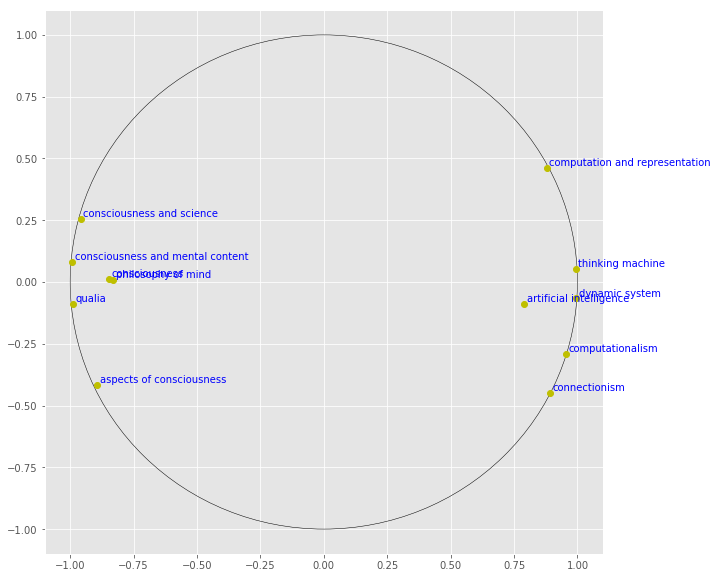

In [209]:
pplot(vocab_dict, embeddings)

In [211]:
embeddings2 = torch.Tensor(vocab_size, embed_dim)
torch.nn.init.uniform(embeddings2, a=-0.001, b=0.001)
train(embeddings2, trans_closure_und, vocab_dict, 4, 0.2, 0.01)

Loss: 1.38593	Average: 1.38593
Loss: 1.38721	Average: 1.38657
Loss: 1.41022	Average: 1.39445
Loss: 1.3861	Average: 1.39236
Loss: 1.37608	Average: 1.38911
Loss: 1.38191	Average: 1.38791
Loss: 1.41642	Average: 1.39198
Loss: 1.36035	Average: 1.38803
Loss: 1.36234	Average: 1.38517
Loss: 1.43893	Average: 1.39055
Loss: 1.38667	Average: 1.39019
Loss: 1.3745	Average: 1.38889
Loss: 1.41616	Average: 1.39098
Loss: 1.36556	Average: 1.38917
Loss: 1.33877	Average: 1.38581
Loss: 1.40504	Average: 1.38701
Loss: 1.37828	Average: 1.3865
Loss: 1.36414	Average: 1.38526
Loss: 1.39083	Average: 1.38555
Loss: 1.32865	Average: 1.3827
Loss: 1.33587	Average: 1.38047
Loss: 1.38967	Average: 1.38089
Loss: 1.3523	Average: 1.37965
Loss: 1.38919	Average: 1.38005
Loss: 1.3938	Average: 1.3806
Loss: 1.32981	Average: 1.37864
Loss: 1.34048	Average: 1.37723
Loss: 1.33859	Average: 1.37585
Loss: 1.29773	Average: 1.37316
Loss: 1.32923	Average: 1.37169
Loss: 1.33709	Average: 1.37058
Loss: 1.35216	Average: 1.37
Loss: 1.35589	Aver

/home/hanshan/anaconda3/envs/py35/lib/python3.5/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


Loss: 1.09471	Average: 1.24867
Loss: 0.878741	Average: 1.24617
Loss: 0.833795	Average: 1.2434
Loss: 1.13042	Average: 1.24265
Loss: 1.15575	Average: 1.24207
Loss: 1.24194	Average: 1.24207
Loss: 1.12267	Average: 1.24129
Loss: 0.980101	Average: 1.23959
Loss: 1.39197	Average: 1.24058
Loss: 1.01717	Average: 1.23914
Loss: 1.3215	Average: 1.23967
Loss: 0.991496	Average: 1.2381
Loss: 1.02202	Average: 1.23674
Loss: 1.22059	Average: 1.23664
Loss: 1.12339	Average: 1.23594
Loss: 1.05115	Average: 1.23479
Loss: 1.11017	Average: 1.23403
Loss: 1.01265	Average: 1.23268
Loss: 0.784251	Average: 1.22996
Loss: 1.40161	Average: 1.231
Loss: 1.12129	Average: 1.23034
Loss: 1.03589	Average: 1.22918
Loss: 1.12435	Average: 1.22856
Loss: 0.750432	Average: 1.22575
Loss: 0.950221	Average: 1.22414
Loss: 1.17601	Average: 1.22386
Loss: 0.967067	Average: 1.22237
Loss: 0.706859	Average: 1.21941
Loss: 1.26733	Average: 1.21968
Loss: 1.22816	Average: 1.21973
Loss: 1.51456	Average: 1.2214
Loss: 0.959291	Average: 1.21993
Loss

Loss: -3.86852	Average: 0.713761
Loss: 0.7621	Average: 0.713869
Loss: 0.148062	Average: 0.712606
Loss: -1.65497	Average: 0.707333
Loss: 0.299456	Average: 0.706427
Loss: 1.15429	Average: 0.70742
Loss: -0.233886	Average: 0.705337
Loss: 0.32442	Average: 0.704496
Loss: 1.019	Average: 0.705189
Loss: -4.04974	Average: 0.694739
Loss: 0.134376	Average: 0.69351
Loss: 0.296103	Average: 0.69264
Loss: -4.27899	Average: 0.681785
Loss: -0.144479	Average: 0.679985
Loss: 1.2982	Average: 0.681329
Loss: 0.478572	Average: 0.680889
Loss: 3.54423	Average: 0.687087
Loss: 0.401761	Average: 0.68647
Loss: 0.848018	Average: 0.686819
Loss: 0.303648	Average: 0.685995
Loss: 0.589932	Average: 0.685788
Loss: 0.594816	Average: 0.685594
Loss: -4.05315	Average: 0.675468
Loss: 1.11688	Average: 0.676409
Loss: 0.351506	Average: 0.675718
Loss: -4.26901	Average: 0.66522
Loss: -0.161967	Average: 0.663467
Loss: 0.920431	Average: 0.66401
Loss: 2.9156	Average: 0.668761
Loss: 2.42713	Average: 0.672462
Loss: 3.73277	Average: 0.67

Loss: 1.21459	Average: 0.043742
Loss: 5.04612	Average: 0.0502896
Loss: 0.486733	Average: 0.0508602
Loss: 0.545788	Average: 0.0515063
Loss: -4.00075	Average: 0.046223
Loss: 0.0891251	Average: 0.0462789
Loss: -0.13589	Average: 0.046042
Loss: 1.79922	Average: 0.0483188
Loss: 0.890198	Average: 0.0494108
Loss: 1.20999	Average: 0.0509142
Loss: -8.8582	Average: 0.0393888
Loss: 5.12013	Average: 0.0459531
Loss: 4.81131	Average: 0.0521019
Loss: 0.644503	Average: 0.0528653
Loss: 1.30049	Average: 0.054471
Loss: -4.63979	Average: 0.0484372
Loss: 0.266024	Average: 0.0487166
Loss: 1.28221	Average: 0.0502979
Loss: 0.510507	Average: 0.0508872
Loss: -8.89713	Average: 0.0394447
Loss: 0.324881	Average: 0.0398093
Loss: 0.268381	Average: 0.0401008
Loss: -8.59034	Average: 0.0291066
Loss: 1.04862	Average: 0.0304037
Loss: 0.0779563	Average: 0.0304641
Loss: 0.132087	Average: 0.0305931
Loss: 0.421462	Average: 0.0310885
Loss: 0.0972114	Average: 0.0311722
Loss: 5.68901	Average: 0.0383249
Loss: 0.249338	Average: 0.

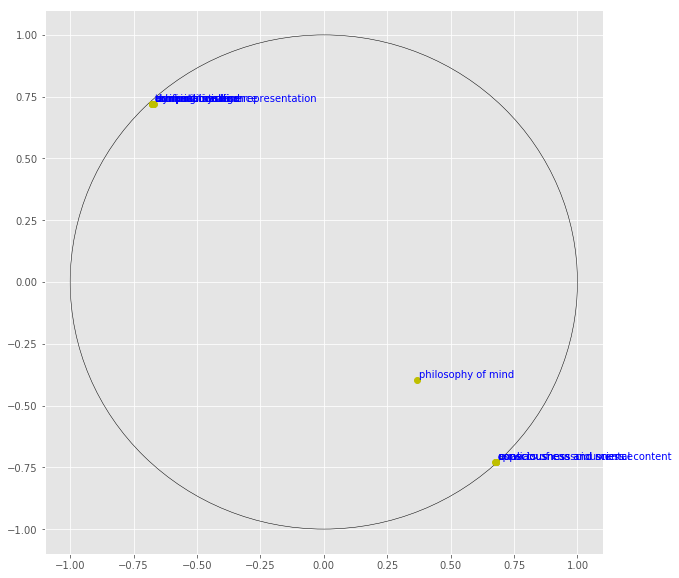

In [212]:
pplot(vocab_dict, embeddings2)

Interesting result: it looks like the higher number of nodes on the right pushes the root node off to the left.

I really don't like this loss function and I suspect a better one may be superior.

I should also try a larger tree. Although the smaller tree is a nice way to get a feel for the dynamics of the learning algorithm.

The undirected transitive closure is also bollocks. I need to double check that concept.

I also need to try the author's own dataset.

To do:
1) tidy this code
2) try and visualize how the learning algorithm works
3) double check my understanding of transitive closure
4) try the wordnet experiment (mammals at least)
5) experiment with different loss functions

Mini-batch it? Nah, got to get it stable first...

Intuition:
- The u in the top term seems key - if it was the child in the hypernymy relationship, that might on average stabilize the pos-neg loss, minimizing the distance to any potential children in that tree (although I guess no guarantee). Actually, no, that doesn't sound right.